In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from datetime import datetime
import scipy.stats

plt.rcParams.update(
    {
        "text.usetex": True,
        "font.family": "sans-serif",
        "font.sans-serif": ["Times New Roman"],
    }
)
plt.rcParams["font.family"] = "Times New Roman"

# Design space exploration

Beyond the most trivial problems, the design space is a complex high-dimensional space filled with many local minima and maxima. Navigating this space in search of optimal or feasible solutions is a non-trivial task. In many engineering applications, evaluating the objective function at a single point requires running a computationally expensive simulation, which can take anywhere from hours to days to complete. Consequently, it is imperative to search the design space efficiently.

In this notebook, we visually demonstrate various concepts using a 2D design space defined by parameters $X_1$ and $X_2$, alongside a known objective function shape $f(X_1, X_2)$. Users can select the objective function shape from a variety of examples, including *double-banana-shaped* distributions and multi-modal Gaussian distributions.

The following concepts are elucidated:

- **Grid Search**: A straightforward exploration method that evaluates points on a grid. While easy to implement, it suffers from the curse of dimensionality, making it inefficient in high-dimensional spaces.

- **Monte Carlo Sampling**: A statistical method that randomly samples points in the design space. It offers a way to explore large areas quickly but may not focus on the most promising regions.

- **Optimisation**: The objective of optimisation is to identify the best solution according to a specified objective function. It involves systematically searching for the global maximum or minimum.

- **Markov Chain Monte Carlo (MCMC)**: MCMC samplers navigate the design space by producing samples that are preferentially drawn from areas of higher probability or likelihood. This method effectively focuses the exploration on the most promising design solutions.

In [2]:
class Animation:

    def __init__(self, objective=None, contour_levels=40, cmap='viridis', name=None, batch_size=5, clear_frame=False):
        """
        Animation class for visualising 2D objective functions and optimisation points.

        Parameters
        ----------
        objective : callable or None
            Function to generate Z values over a meshgrid (X1, X2). Optional if you provide Z directly

        contour_levels : int
            Number of contour levels for the objective

        cmap : str
            Matplotlib colormap for scatter and contour

        name : str
            Name of the output animation file. Defaults to timestamped name

        batch_size : int
            Number of points to show per frame.

        clear_frame : bool
            If True, each frame only shows the current batch.
            If False, points accumulate over frames.
        """
        self.objective = objective
        self.contour_levels = contour_levels
        self.cmap = cmap
        self.name = name or self._generate_animation_name()
        self.batch_size = batch_size
        self.clear_frame = clear_frame

        self.samples = None
        self.values = None

    @staticmethod
    def _generate_animation_name():
        timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
        return f"{timestamp}-animation.gif"

    def set_data(self, samples, values=None):
        """
        Set the scatter points and their associated values.

        Parameters
        ----------
        samples : array-like, shape (N, 2)
            The (X1, X2) coordinates of points

        values : array-like, shape (N,)
            Objective function values at each sample
        """
        self.samples = np.array(samples)
        self.values = np.array(values) if values is not None else None

    @staticmethod
    def _compute_marker_sizes(n_points, max_size=15, min_size=0.5):
        """
        Generate exponentially increasing marker sizes for visual emphasis
        """
        x = np.linspace(0, 1, n_points)
        base = 1E2
        y = np.power(base, x) - 1 / (base - 1)
        sz = y / np.max(y) * max_size
        sz = np.maximum(sz, min_size)
        return sz

    def _update(self, i, sc):
        """
        Update scatter for frame i
        """
        if self.clear_frame:
            start_index = 0
        else:
            start_index = 0  # always accumulate from first sample

        end_index = min((i + 1) * self.batch_size, len(self.samples))
        batch_samples = self.samples[:end_index]
        sz = self._compute_marker_sizes(end_index)

        sc.set_offsets(batch_samples)
        sc.set_sizes(sz)

        if self.values is not None:
            batch_values = self.values[:end_index]
            sc.set_array(batch_values)
        else:
            sc.set_color('black')

        return sc,

    def generate(self, X1, X2, Z=None, interval=100, save=True, dpi=200):
        """
        Generate and optionally save the animation.

        Parameters
        ----------
        X1, X2 : 2D arrays
            Meshgrid coordinates for contour

        Z : 2D array
            Objective function values on the meshgrid. Optional if self.objective is provided

        interval : int
            Time between frames in milliseconds

        save : bool
            If True, save as GIF

        dpi : int
            DPI for saved GIF.
        """
        if Z is None:
            if self.objective is None:
                raise ValueError("Must provide Z or an objective function.")
            Z = self.objective(X1, X2)
    
        if self.samples is None:
            raise ValueError("Scatter data not set. Call `set_data(samples, values)` first.")
    
        fig, ax = plt.subplots(figsize=(10, 8), constrained_layout=True)
        ax.contour(X1, X2, Z, levels=self.contour_levels, alpha=0.25, cmap=self.cmap)
    
        # Initialise scatter
        if self.values is not None:
            vmin, vmax = np.min(self.values), np.max(self.values)
            sc = ax.scatter([], [], c=[], cmap=self.cmap, vmin=vmin, vmax=vmax, zorder=5)
        else:
            sc = ax.scatter([], [], color='black', zorder=5)  # no values, black points
    
        ax.set_xlabel('$X_1$')
        ax.set_ylabel('$X_2$')
        ax.set_title('Design space')
        ax.set_frame_on(False)
        ax.set_xticks([])
        ax.set_yticks([])
    
        num_frames = (len(self.samples) + (self.batch_size - 1)) // self.batch_size
    
        ani = animation.FuncAnimation(
            fig, self._update, frames=num_frames, fargs=(sc,), interval=interval, blit=True
        )
    
        if save:
            ani.save(self.name, writer=animation.PillowWriter(fps=30), dpi=dpi)
    
        plt.close(fig)
        return ani

## Design space

**Banana:**

Below is a simple implementation of a banana-shaped posterior distribution. This function creates a banana-shaped posterior distribution by combining a quadratic term $(x_2 - x_1^2)^2$ with a Gaussian-like term $(x_1 - 2)^2$, exponentiated to ensure positivity. Adjusting the coefficients and terms can modify the shape and size of the "banana".

In [3]:
def banana(x):
    x1, x2 = x
    return np.exp(-0.1 * ((x2 - x1**2) ** 2 + (x1 - 2) ** 2))

In [4]:
def banana(x, a=2, b=0.01):
    """
    Smooth banana-shaped function with adjustable position and curvature.

    f(x1, x2) = exp[-b * ((x2 - x1^2)^2 + (x1 - a)^2)]

    Parameters
    ----------
    x : array-like of shape (2,)
        Input vector [x1, x2].

    a : float, default=2
        Controls the horizontal position of the peak (along x1).
        The function reaches its maximum near (x1, x2) = (a, a^2).

    b : float, default=0.1
        Controls the curvature and sharpness of the valley.
        Larger values of b produce a narrower and steeper banana;
        smaller values make it broader and flatter.

    Returns
    -------
    f : float
        Function value in the range (0, 1].
    """
    x1, x2 = x
    return np.exp(-b * ((x2 - x1**2)**2 + (x1 - a)**2))

In [5]:
def double_banana(x, peaks=(1.0, 1.5), offsets=(0.0, 6.0), scales=(0.1, 0.2), curvatures=(-1, 1)):
    x1, x2 = x
    bananas = [
        peak * np.exp(-scale * ((x2 - curvature * (x1 - offset)**2) ** 2 + (x1 - offset - 2) ** 2))
        for peak, offset, scale, curvature in zip(peaks, offsets, scales, curvatures)
    ]
    return sum(bananas)

In [6]:
def weighted_multi_gaussian_mixture(x):
    x1, x2 = x
    means = [(0, 0), (2, 7), (5, 4)]
    stds = [1.5, 0.5, 1]
    weights = [0.3, 0.8, 0.2]
    return sum(
        w * np.exp(-((x1 - mean[0]) ** 2 + (x2 - mean[1]) ** 2) / (2 * std**2))
        for mean, std, w in zip(means, stds, weights)
    )

In [7]:
design_space = double_banana

In [8]:
def plot_design_space(X1, X2, Z, X1_scatter=None, X2_scatter=None, levels=40, c='black'):
    plt.figure(figsize=(10, 8))
    plt.contour(X1, X2, Z, levels=levels, cmap='viridis')
    plt.xlabel('$X_1$')
    plt.ylabel('$X_2$')
    plt.title('Design space')
    plt.gca().set_frame_on(False)
    plt.xticks([])
    plt.yticks([])

    if X1_scatter is not None and X2_scatter is not None:
        plt.scatter(X1_scatter, X2_scatter, c=c, s=0.5, zorder=5)

8.013013013013014 4.06406406406407


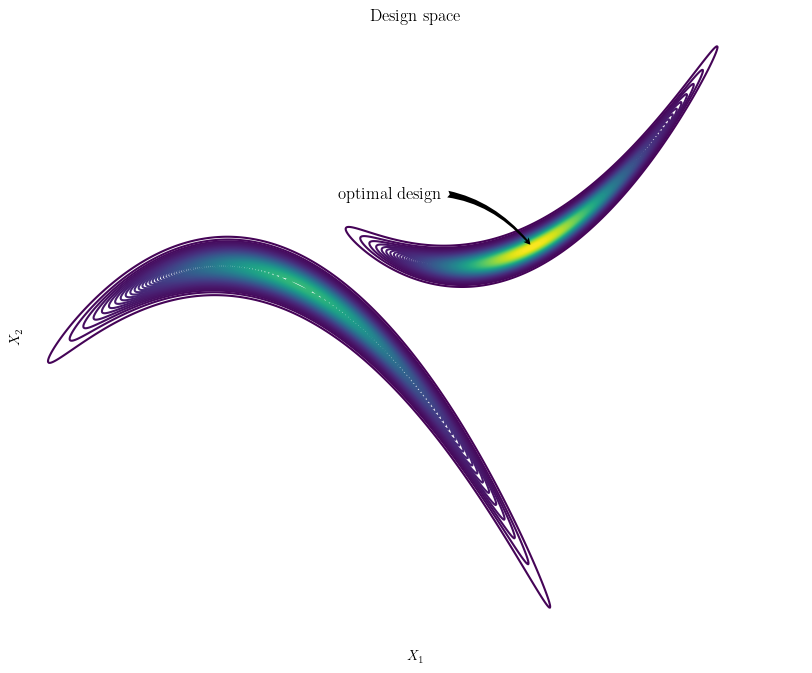

In [9]:
x1_range = np.linspace(-5, 15, 1000)
x2_range = np.linspace(-80, 50, 1000)
X1, X2 = np.meshgrid(x1_range, x2_range)
Z = np.array([[design_space((x1, x2)) for x1 in x1_range] for x2 in x2_range])
Z = np.where(Z > 0.01, Z, np.nan)

max_index = np.unravel_index(np.nanargmax(Z), Z.shape)
x1_max, x2_max = X1[max_index], X2[max_index]
print(x1_max, x2_max)

plot_design_space(X1, X2, Z, levels=100)

plt.annotate(
    'optimal design',
    xy=(x1_max, x2_max),
    xytext=(x1_max - 5, x2_max + 10),
    fontsize=12,
    ha='left',
    color='black',
    arrowprops=dict(
        arrowstyle='fancy',
        connectionstyle='arc3,rad=-0.3',
        facecolor='black',
        edgecolor='none'
    )
)

plt.savefig('design-space.png', dpi=300, bbox_inches='tight')

## Grid search

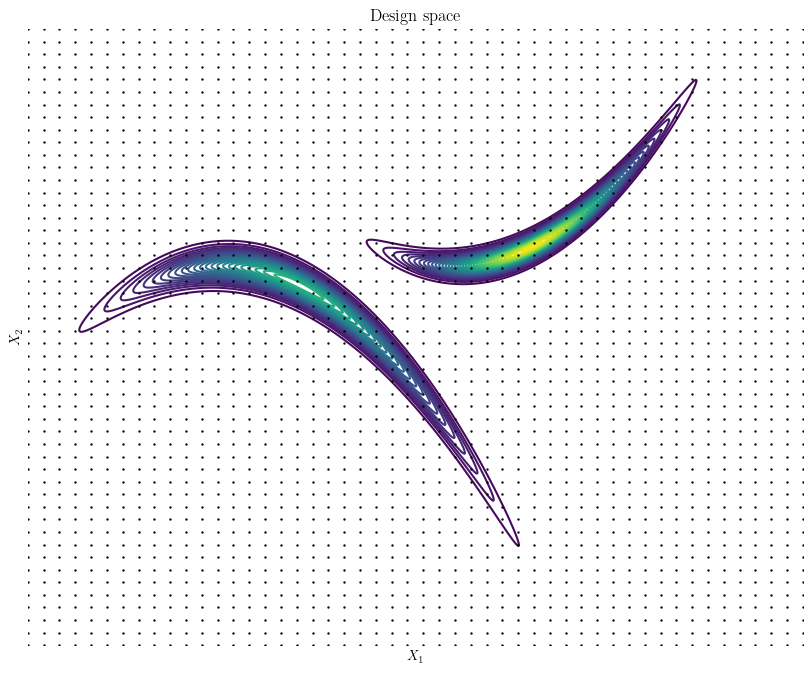

In [10]:
x1_search = np.linspace(-5, 15, 50)
x2_search = np.linspace(-80, 50, 50)
X1_search, X2_search = np.meshgrid(x1_search, x2_search)

plot_design_space(X1, X2, Z, X1_search, X2_search)
plt.savefig('grid-search.png', dpi=300, bbox_inches='tight')

In [11]:
grid_search = False

if grid_search:
    anim = Animation(batch_size=5, name="grid-search.gif")
    samples = np.column_stack([X1_search.ravel(), X2_search.ravel()])
    anim.set_data(samples)
    ani = anim.generate(X1, X2, Z, interval=50, save=True)

## Monte Carlo

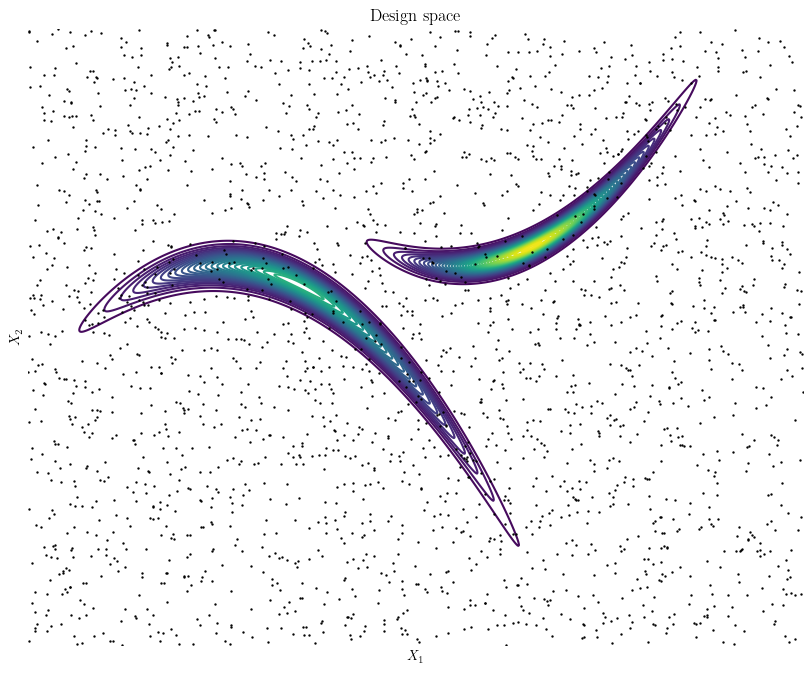

In [12]:
X1_mc = np.random.uniform(-5, 15, 2500)
X2_mc = np.random.uniform(-80, 50, 2500)

plot_design_space(X1, X2, Z, X1_mc, X2_mc)
plt.savefig('monte-carlo.png', dpi=300, bbox_inches='tight')

## Adaptive Metropolis Hastings (`Sampler` and `Proposal` class)

In [13]:
from tqdm import tqdm


class Sampler:

    def __init__(self, posterior, proposal, steps, init):
        self.posterior = posterior
        self.proposal = proposal
        self.steps = int(steps)  # n_samples
        self.init = init
        self.samples = None

    def sample(self):
        """
        Sampling
        """
        self.samples = [self.init.copy()]
        for _ in tqdm(range(self.steps), desc="Sampling"):
            self._sample_step()

    def get_samples(self):
        """
        Returns the samples
        """
        return np.array(self.samples)

    def _sample_step(self):
        """
        Draw a new sample
        """
        point = self.samples[-1]
        proposal = self.proposal.draw(self.samples)
        self.samples.append(self._accept_or_reject(point, proposal))

    def _accept_or_reject(self, x_i, x_p):
        """
        Accept of reject a new candidate

        Parameters
        ----------
        x_i : ndarray
            Current sample

        x_p : ndarray
            New sample (x_p) is proposed by drawing from a proposal
            distribution

        n_accept : int
            Count of accepted samples

        Returns
        -------

        """
        alpha = self._compute_acceptance_ratio(x_i, x_p)
        u = np.random.uniform(low=0.0, high=1.0)
        if u <= alpha:  # Accept proposal
            return x_p
        else:  # Reject proposal
            return x_i

    def _compute_acceptance_ratio(self, x_i, x_p):
        return min(1, self.posterior.evaluate(x_p) / self.posterior.evaluate(x_i))


class MetropolisHastings(Sampler):
    pass

In [14]:
class Proposal:
    """
    Proposal class

    TODO: look at pysampler/proposal.py
    """

    def __init__(self, step_size):
        self.step_size = step_size

    def draw(self, samples):
        return np.random.normal(samples[-1], self.step_size)


class GaussianProposal(Proposal):
    pass


class AdaptiveProposal:
    """
    Adaptive proposal class - update the the covariance matrix of the proposal
    distribution using existing knowledge of the posterior

    Haario, H., Saksman, E., and Tamminen, J. (1999). Adaptive proposal
    distribution for random walk metropolis algorithm. Computational
    Statistics, 14(3):375-395. 1, 2

    Attributes
    ----------
    update_freq: int
        Proposal distribution update frequency (default = 1000). The
        frequency at which the proposal distribution is updated.

    n_K : ndarray
        Number of samples / update frequency

    R_0 : ndarray (floats)
        Initial covariance matrix (this can be chosen as the identify matrix
        if you have no prior knowledge)

    R_t : ndarray (floats)
        Updated covariance matrix

    i : int
        Counter to track how many times the proposal has been called

    Notes
    -----
    - TODO: is n_K equal to n_samples?
    - TODO: gamma is missing from the draw method
    """

    def __init__(self, cov, step_size=2.38, update_freq=1000):
        self.cov = cov
        self.step_size = step_size
        self.update_freq = update_freq
        self.R_t = cov
        self.i = 0

    def draw(self, samples):
        """
        Draw x (candidate) from proposal distribution q

        Parameters
        ----------
        x_i : ndarray
            Current sample

        Returns
        -------
        x_p : ndarray
            Proposed sample (candidate sample)

        """
        self.i += 1
        if self.i % self.update_freq == 0:
            self._adapt_cov(samples)
        return np.random.multivariate_normal(samples[-1], self.R_t)

    def _adapt_cov(self, K):
        """
        Parameters
        ----------
        K : ndarray

        Returns
        -------
        R_t : ndarray (floats)
            Updated covariance matrix
        """
        K_tilde = self._compute_K_tilde(K)
        self.R_t = (1 / (len(K) - 1)) * np.matmul(np.transpose(K_tilde), K_tilde)

    def _compute_K_tilde(self, K):
        """
        Calculate the centred matrix

        Parameters
        ----------
        K : ndarray
            Sample chain - all previous samples are stored in matrix K of size
            n_k x n_p, where n_k is... and n_p is the number of unknown
            parameters. Each row represents one sampled point.

        K_mean : ndarray
            History (evolution) of mean value of all previous samples
            (n_samples x n_p)

        Returns
        -------
        K_tilde : ndarray
            The centred matrix n_K x n_p (K_tilde = K - E[K])
        """
        return K - np.mean(K, 0)

In [15]:
class Posterior:

    def __init__(self, distribution):
        self.distribution = distribution

    def evaluate(self, x):
        """
        Evaluate the posterior distribution for given model parameters and observed data.

        Parameters
        ----------
        x : float or array-like
            The value(s) of the model parameters.

        Returns
        -------
        float or array-like
            The posterior probability distribution for the given model parameters.
        """
        return self.distribution(x)

    def plot(self, ax=None, x1_range=np.linspace(-10, 10, 1000), x2_range=np.linspace(-10, 10, 1000)):
        """
        Plot the full posterior distribution
        """
        X1, X2 = np.meshgrid(x1_range, x2_range)
        Z = np.array([[self.evaluate((x1, x2)) for x1 in x1_range] for x2 in x2_range])
        Z = np.where(Z > 0.01, Z, np.nan)  # Mask values below a threshold

        if ax is None:
            fig, ax = plt.subplots(figsize=(10, 8), constrained_layout=True)

        ax.contour(X1, X2, Z, levels=40, cmap='viridis')
        ax.set_xlabel('X1')
        ax.set_ylabel('X2')
        plt.gca().set_frame_on(False)
        plt.xticks([])
        plt.yticks([])
        return ax

In [16]:
posterior = Posterior(distribution=design_space)
proposal = AdaptiveProposal(cov=np.eye(2), step_size=[1, 1])
mh = Sampler(posterior, proposal, 0.2e5, np.array([0, 10]))
mh.sample()
samples = mh.get_samples()

Sampling: 100%|█████████████████████████████████████████████████████████████████████| 20000/20000 [00:00<00:00, 31108.32it/s]


In [17]:
def scatter_hist(x, y, p, ax, ax_histx, ax_histy):
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    ax.scatter(x, y, s=1, c=p)

    xbinwidth = (np.max(x) - np.min(x)) / 100
    ybinwidth = (np.max(y) - np.min(y)) / 100
    xbins = np.arange(np.min(x), np.max(x) + xbinwidth, xbinwidth)
    ybins = np.arange(np.min(y), np.max(y) + ybinwidth, ybinwidth)
    ax_histx.hist(x, bins=xbins, density=True, histtype="step")
    ax_histy.hist(
        y, bins=ybins, density=True, histtype="step", orientation="horizontal"
    )

    for a in [ax, ax_histx, ax_histy]:
        a.set_xticks([])
        a.set_yticks([])
        for spine in a.spines.values():
            spine.set_visible(False)
        a.set_frame_on(False)

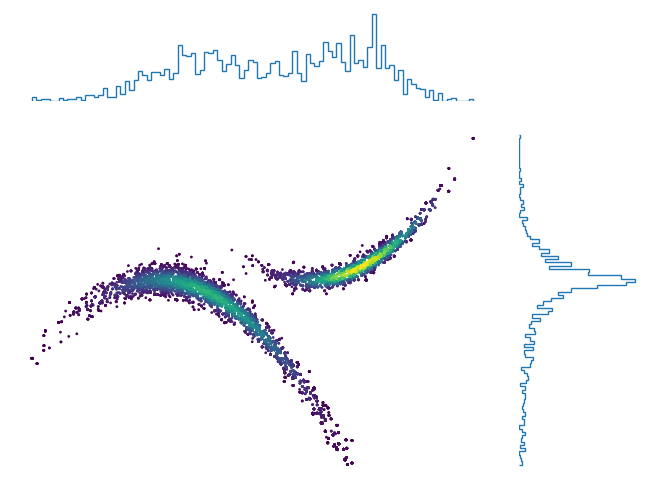

In [18]:
fig = plt.figure(layout="constrained")
ax = fig.add_gridspec(top=0.75, right=0.75).subplots()
ax_histx = ax.inset_axes([0, 1.05, 1, 0.25], sharex=ax)
ax_histy = ax.inset_axes([1.05, 0, 0.25, 1], sharey=ax)
p = [
    posterior.evaluate(sample) for sample in samples
]  # TODO: save this in the Sampler class
scatter_hist(samples[:, 0], samples[:, 1], p, ax, ax_histx, ax_histy)

/Users/markhobbs/.local/share/virtualenvs/design-space-exploration-omQwsQX-/lib/python3.11/site-packages/numpy/lib/_histograms_impl.py:902: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


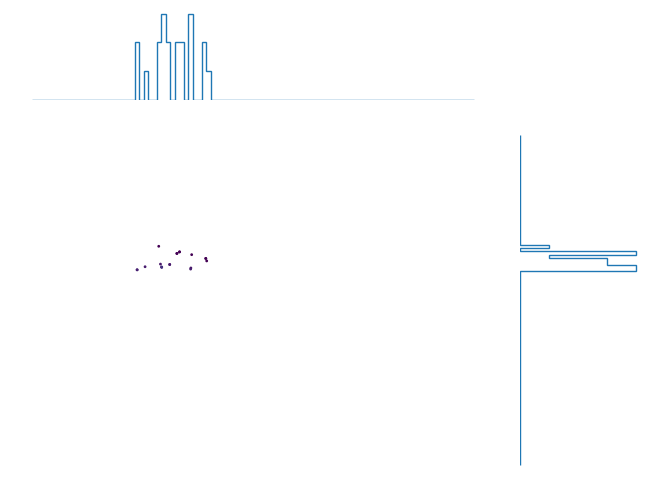

In [19]:
marginal_posterior = True

if marginal_posterior:
    def scatter_hist(x, y, p, ax, ax_histx, ax_histy):
        sc = ax.scatter([], [], s=1, c=[], cmap='viridis', vmin=np.min(p), vmax=np.max(p))
    
        # Initialise empty histograms
        xbins = np.linspace(np.min(x), np.max(x), 100)
        ybins = np.linspace(np.min(y), np.max(y), 100)
        hx = ax_histx.hist([], bins=xbins, density=True, histtype="step")[2][0]
        hy = ax_histy.hist([], bins=ybins, density=True, histtype="step", orientation="horizontal")[2][0]
    
        # Turn off axes, ticks, and spines
        for a in [ax, ax_histx, ax_histy]:
            a.set_xticks([])
            a.set_yticks([])
            for spine in a.spines.values():
                spine.set_visible(False)
            a.set_frame_on(False)
    
        return sc, hx, hy, xbins, ybins
    
    fig = plt.figure(layout="constrained")
    ax = fig.add_gridspec(top=0.75, right=0.75).subplots()
    ax_histx = ax.inset_axes([0, 1.05, 1, 0.25], sharex=ax)
    ax_histy = ax.inset_axes([1.05, 0, 0.25, 1], sharey=ax)
    
    p = [posterior.evaluate(sample) for sample in samples]
    
    sc, hx, hy, xbins, ybins = scatter_hist(samples[:, 0], samples[:, 1], p, ax, ax_histx, ax_histy)
    
    batch_size = 20
    num_frames = (len(samples) + batch_size - 1) // batch_size
    
    def update(frame):
        end_index = min((frame + 1) * batch_size, len(samples))
        x, y = samples[:end_index, 0], samples[:end_index, 1]
        pvals = p[:end_index]
    
        # Update scatter
        sc.set_offsets(np.column_stack((x, y)))
        sc.set_array(np.array(pvals))
    
        # Update histograms
        ax_histx.cla()
        ax_histy.cla()
        ax_histx.hist(x, bins=xbins, density=True, histtype="step")
        ax_histy.hist(y, bins=ybins, density=True, histtype="step", orientation="horizontal")
    
        # Remove axes again (cla() resets them)
        for a in [ax_histx, ax_histy]:
            a.set_xticks([])
            a.set_yticks([])
            for spine in a.spines.values():
                spine.set_visible(False)
            a.set_frame_on(False)
    
        return sc,
    
    ani = animation.FuncAnimation(
        fig, update, frames=num_frames, interval=100, blit=False, repeat=False
    )
    ani.save('marginal-posterior.mp4', writer='ffmpeg', fps=15, dpi=150)

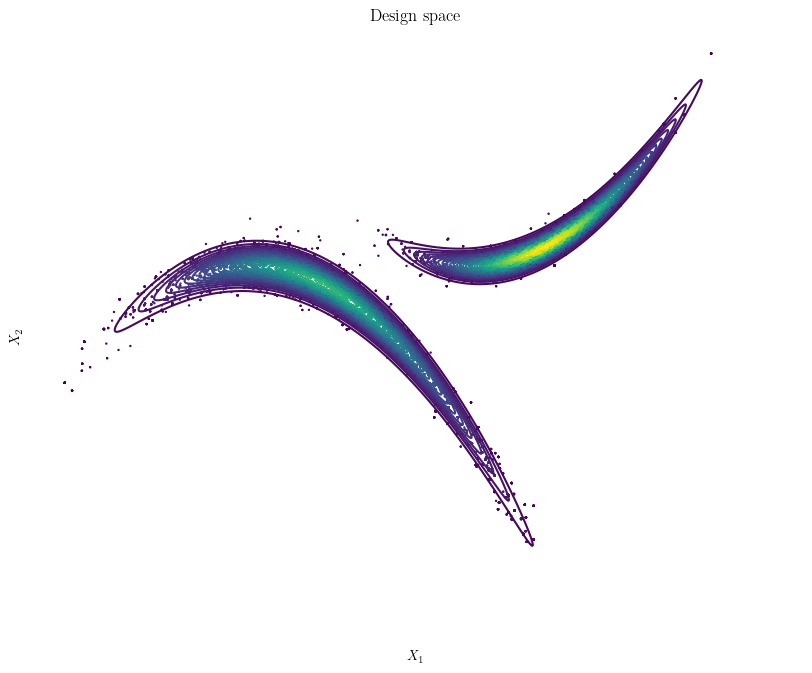

In [20]:
plot_design_space(X1, X2, Z, samples[:, 0], samples[:, 1], c=p)
plt.savefig('mcmc.png', dpi=300, bbox_inches='tight')

In [21]:
mcmc_animation = False

if mcmc_animation:
    anim = Animation(batch_size=5, name="mcmc-animation.gif")
    anim.set_data(samples[10000:], p[10000:])
    ani = anim.generate(X1, X2, Z, interval=50, save=True)

## Gradient-based optimisation

In [22]:
class GradientDescent:
    """
    Basic gradient descent
    """

    def __init__(self, posterior, initial_candidate):
        self.posterior = posterior
        self.candidate = initial_candidate

    def optimise(self, step_size, n_steps=100):
        """
        Optimise the cost function using gradient descent.

        Parameters:
        step_size (float): Learning rate for the gradient descent.
        n_steps (int): Number of iterations for the gradient descent.

        Returns:
        """
        cost_hist = []
        candidate_hist = []

        for _ in range(n_steps):
            gradient = self._compute_gradient()
            self.candidate -= step_size * gradient
            candidate_hist.append(np.copy(self.candidate))
            cost_hist.append(self._cost_function(self.candidate))

        return np.array(candidate_hist), cost_hist

    def _compute_gradient(self, h=1e-5):
        """
        Employ the finite difference method to compute the gradient of the
        cost function with respect to the model parameters.

        Parameters:
        h (float, optional): The step size for the finite difference approximation. Default is 1e-5.

        Returns:
        numpy array: The gradient of the cost function at the current candidate parameters.
        """
        x = self.candidate
        gradient = np.zeros_like(x)

        for i in range(len(x)):
            x_forward, x_backward = np.copy(x), np.copy(x)
            x_forward[i] += h
            x_backward[i] -= h
            gradient[i] = (
                self._cost_function(x_forward) - self._cost_function(x_backward)
            ) / (2 * h)

        return gradient

    def _cost_function(self, candidate):
        return self.posterior.evaluate(candidate)

In [23]:
class GradientDescent:
    """
    Stochastic gradient descent with momentum
    """

    def __init__(self, posterior, initial_candidate_range, num_random_starts=5):
        
        self.posterior = posterior
        self.initial_candidate_range = initial_candidate_range
        self.num_random_starts = num_random_starts
        self.num_parameters = len(initial_candidate_range)

    def optimise(self, step_size, n_steps=100, momentum=0.9):
        """
        Optimise the cost function using stochastic gradient descent with momentum.

        Parameters:
        step_size (float): Learning rate for the gradient descent
        
        n_steps (int): Number of iterations for the gradient descent.
        
        momentum (float): Momentum factor.
        
        batch_size (int): Number of data points to use in each mini-batch.

        Returns:
        """
        best_candidate = None
        best_cost = float('inf')
        best_candidate_hist = None
        best_cost_hist = None

        for _ in range(self.num_random_starts):

            self.candidate = self._initialise_candidate()
            
            cost_hist = []
            candidate_hist = []
            velocity = np.zeros_like(self.candidate)

            for _ in range(n_steps):
                gradient = self._compute_gradient()
                velocity = momentum * velocity - step_size * gradient
                self.candidate += velocity
                candidate_hist.append(np.copy(self.candidate))
                cost = self._cost_function(self.candidate)
                cost_hist.append(cost)

            if cost_hist[-1] < best_cost:
                best_cost = cost_hist[-1]
                best_candidate = np.copy(self.candidate)
                best_candidate_hist = candidate_hist
                best_cost_hist = cost_hist

        return np.array(best_candidate_hist), np.array(best_cost_hist)

    def _initialise_candidate(self):
        return np.array([np.random.uniform(lower_bound, upper_bound) 
                         for lower_bound, upper_bound in self.initial_candidate_range])

    def _compute_gradient(self, h=1e-5):
        """
        Employ the finite difference method to compute the gradient of the
        cost function with respect to the model parameters.

        Parameters:
        h (float, optional): The step size for the finite difference approximation. Default is 1e-5.

        Returns:
        numpy array: The gradient of the cost function at the current candidate parameters.
        """
        x = self.candidate
        gradient = np.zeros_like(x)

        for i in range(len(x)):
            x_forward, x_backward = np.copy(x), np.copy(x)
            x_forward[i] += h
            x_backward[i] -= h
            gradient[i] = (
                self._cost_function(x_forward) - self._cost_function(x_backward)
            ) / (2 * h)

        return gradient

    def _cost_function(self, candidate):
        return -self.posterior.evaluate(candidate)

In [24]:
X1_init_range = np.array([0, 5])
X2_init_range = np.array([-60, 30])
initial_params = [X1_init_range, X2_init_range]

optimiser = GradientDescent(posterior, initial_params, num_random_starts=5)
candidate_hist, cost_hist = optimiser.optimise(step_size=np.array([0.1, 0.1]), n_steps=100000)

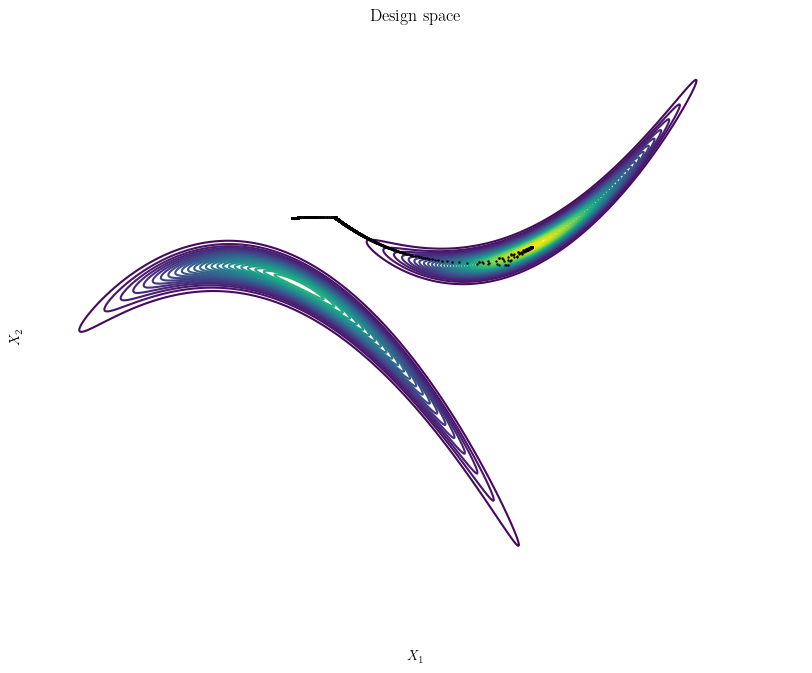

In [25]:
plot_design_space(X1, X2, Z, candidate_hist[:, 0], candidate_hist[:, 1])
plt.savefig('optimisation.png', dpi=300, bbox_inches='tight')

In [26]:
gradient_descent = False

if gradient_descent:
    anim = Animation(batch_size=50, name="gradient-descent.gif")
    samples = np.column_stack([candidate_hist[5000:, 0], candidate_hist[5000:, 1]])
    anim.set_data(samples)
    ani = anim.generate(X1, X2, Z, interval=50, save=True)

## Genetic algorithm

In [27]:
import random
from tqdm import tqdm

class GeneticAlgorithm:

    def __init__(
        self,
        population,
        num_generations=50,
        num_parents=4,
        mutation_probability=0.05,
        animate=False,
    ):
        self.population = population
        self.num_generations = num_generations
        self.num_parents = num_parents
        self.mutation_probability = mutation_probability
        self.animate = animate
        if self.animate:
            self.animation = Animation()
            self.animation.save_frame(self.population)
        self.fitness = []

    def generate_offspring(self):
        new_population = []
        for _ in range(len(self.population.individuals)):
            parent_a, parent_b = random.sample(self.population.parents, 2)
            child = parent_a.crossover(parent_b)
            child.mutate(self.mutation_probability)
            new_population.append(child)

        self.population.individuals = new_population

    def evolutionary_cycle(self):
        self.population.evaluate()
        self.fitness.append(max(self.population.fitness))
        self.population.select_parents(self.num_parents)
        self.generate_offspring()
        if self.animate:
            self.animation.save_frame(self.population)

    def evolve(self):
        for _ in tqdm(range(self.num_generations), desc="Evolution"):
            self.evolutionary_cycle()

        # if self.animate:
        #     self.animation.generate()

    def plot_fitness(self):
        _, ax = plt.subplots(figsize=(8, 4))
        ax.plot(self.fitness)
        ax.set_xlabel("Generation")
        ax.set_ylabel("Fitness")
        ax.set_title("Fitness Evolution")
        ax.grid(True)
        plt.tight_layout()

In [28]:
class Population:

    def __init__(self, individuals):
        self.individuals = individuals
        self.fitness = []
        self.parents = []

    def evaluate(self):
        self.fitness = [individual.fitness() for individual in self.individuals]

    def select_parents(self, num_parents):
        self.parents = sorted(
            self.individuals, key=lambda x: x.fitness(), reverse=True
        )[:num_parents]

    def plot(self):
        fig, ax = plt.subplots(figsize=(10, 8))
        for individual in self.individuals:
            individual.plot(ax)
        plt.tight_layout()
        return fig

In [29]:
class Individual:

    def __init__(self, genes):
        self.genes = genes
        self._fitness = None

    def evaluate_fitness(self):
        """
        This method should be implemented in subclasses to evaluate fitness.
        """
        raise NotImplementedError

    def fitness(self):
        """
        Returns the fitness of the individual. Computes fitness if it has not
        been computed yet.
        """
        if self._fitness is None:
            self.evaluate_fitness()
        return self._fitness

    def crossover(self, partner, alpha=0.5):
        """
        Blend Crossover (BLX-alpha)

        Parameters
        ----------
        partner : Individual
            The other parent individual.
        alpha : float
            The blending parameter that controls the range of crossover.

        Returns
        -------
        child : Individual
            The offspring produced by crossover.
        """
        child = np.zeros_like(self.genes)
        for i in range(len(self.genes)):
            X_min = min(self.genes[i], partner.genes[i])
            X_max = max(self.genes[i], partner.genes[i])
            delta = X_max - X_min
            child[i] = np.random.uniform(X_min - alpha * delta,
                                         X_max + alpha * delta)
        return child

    def mutate(self, mutation_probability, sigma=0.1):
        """
        Gaussian Mutation

        Parameters
        ----------
        mutation_probability : float
            The probability of mutating each gene.
        sigma : float
            The standard deviation of the Gaussian distribution 
            used for mutation.

        Returns
        -------
        None
        """
        for i in range(len(self.genes)):
            if np.random.rand() < mutation_probability:
                self.genes[i] += np.random.normal(0, sigma)

In [30]:
class Design(Individual):

    def __init__(self, genes, posterior):
        super().__init__(genes)
        self.posterior = posterior

    def evaluate_fitness(self):
        self._fitness = self.posterior.evaluate(self.genes)

    def crossover(self, partner):
        return Design(super().crossover(partner), self.posterior)
        
    def mutate(self, mutation_probability):
        super().mutate(mutation_probability)

    def plot(self, ax):
        """
        Plot an individual design
        """
        ax.scatter(self.genes[0], self.genes[1], color='black')

In [31]:
from datetime import datetime

class Animation:

    def __init__(self, name=None):
        self.name = name or self._generate_animation_name()
        self.frames = []

    @staticmethod
    def _generate_animation_name():
        timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
        return f"{timestamp}-animation.gif"
    
    def save_frame(self, population):
        frame_data = [(individual.genes[0], individual.genes[1]) for individual in population.individuals]
        self.frames.append(frame_data)        

    def _update(self, frame_data):
        if hasattr(self, 'scatter'):
            self.scatter.remove()
        
        x_data, y_data = zip(*frame_data)
        self.scatter = self.ax.scatter(x_data, y_data, s=10, color='black', zorder=5)
        self.ax.set_title(f'Generation {self.frames.index(frame_data) + 1}')
    
        return self.ax,

    def generate(self, posterior, interval=1000, pause=1000):
        """
        Parameters
        ----------
        posterior : Posterior instance
            An instance of the Posterior class with a plot method.
        interval : int, optional
            Time between frames (milliseconds)
        pause : int, optional
            Pause at the end of the animation (milliseconds)
        """
        pause_frames = int(pause / interval)
        self.frames.extend([self.frames[-1]] * pause_frames)

        self.fig, self.ax = plt.subplots(figsize=(10, 8), constrained_layout=True)

        posterior.plot(ax=self.ax, x1_range=np.linspace(-5, 15, 1000), x2_range=np.linspace(-80, 50, 1000))

        self.ax.set_xlabel('X1')
        self.ax.set_ylabel('X2')
        plt.gca().set_frame_on(False)
        plt.xticks([])
        plt.yticks([])

        self.ani = animation.FuncAnimation(
            self.fig,
            self._update,
            frames=self.frames,
            interval=interval,
            blit=False,
        )

        self.ani.save(self.name, writer=animation.PillowWriter(fps=1000 / interval))

Evolution: 100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1170.42it/s]


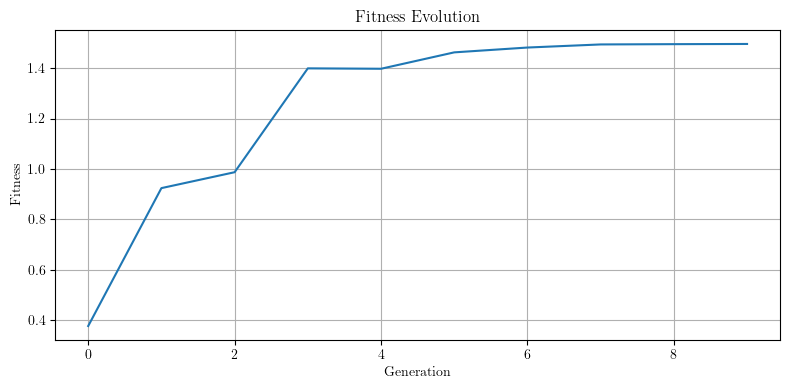

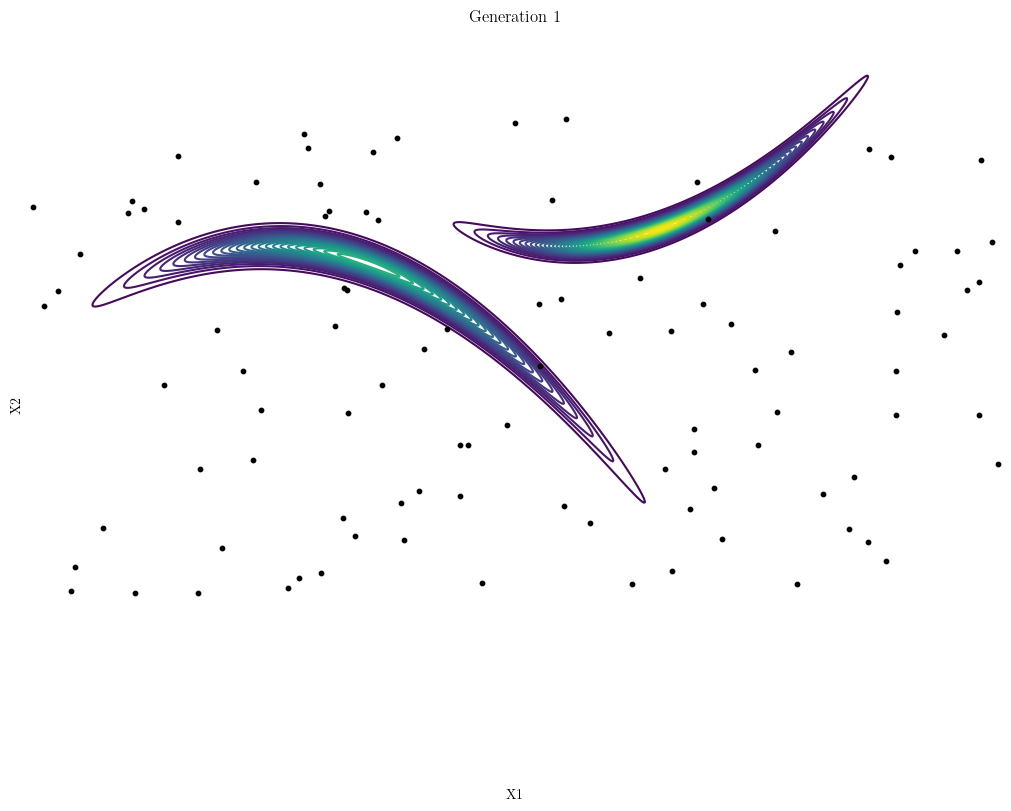

In [32]:
population_size = 100
individuals = [Design(genes=[np.random.uniform(-5, 15), np.random.uniform(-80, 30)], posterior=posterior) 
               for _ in range(population_size)]
population = Population(individuals)

ga = GeneticAlgorithm(population, 
                      num_generations=10, 
                      num_parents=8,
                      mutation_probability=0.05,
                      animate=True)
ga.evolve()
ga.plot_fitness()
ga.animation.generate(posterior)

## Generative models

Generative models aim to infer the underlying distribution from which observed data is generated. When the data exhibits a non-Gaussian, curved pattern (e.g., a banana distribution), traditional Gaussian Mixture Models (GMMs) may struggle to accurately capture the structure, as they assume linear or elliptical clusters.

More flexible methods are better suited for such cases:

1. **Kernel Density Estimation (KDE)**: A non-parametric method that estimates the probability density function by placing a kernel (e.g., Gaussian) on each data point and summing the contributions, without assuming any specific shape.

2. **Normalising Flows**: These use a series of invertible transformations applied to a simple base distribution (like Gaussian noise) to generate complex, non-Gaussian shapes, effectively capturing intricate data structures.

3. **Variational Autoencoders (VAEs) and Generative Adversarial Networks (GANs)**: Deep generative models that learn to map from a latent space to the data space, enabling them to model complex distributions, including highly curved or irregular shapes.

4. **Transformed Gaussian Mixtures**: Applying nonlinear transformations to the data before fitting a GMM can better accommodate curved or non-standard distributions.

While GMMs provide a rough approximation, techniques like KDE, normalising flows, and deep generative models are more suitable for complex high dimensional data. In the engineering domain, deep generative models like GANs and VAEs are used to generate new design candidates by learning the underlying distribution of existing high-performance designs. These models can produce novel design configurations that share desirable characteristics with known solutions.

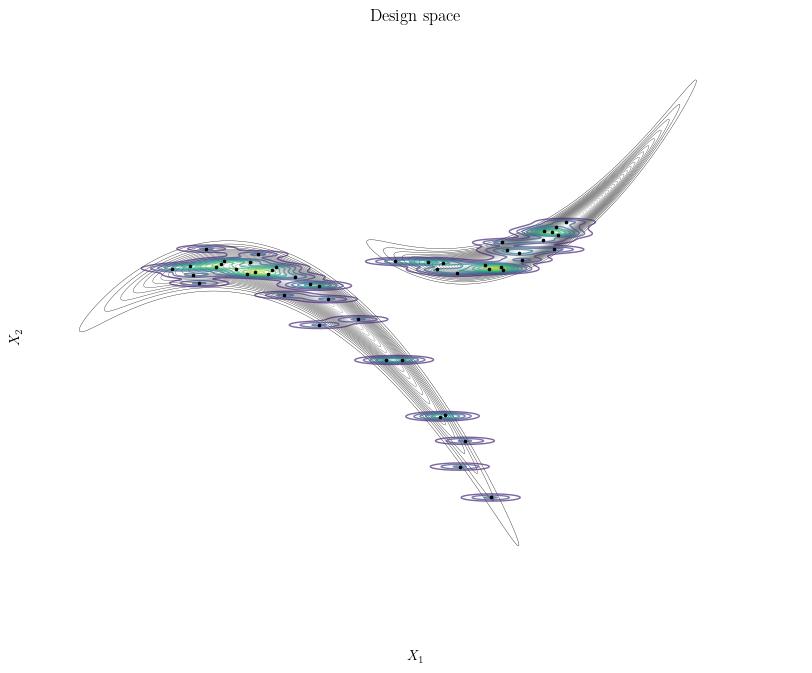

In [33]:
from sklearn.neighbors import KernelDensity

random_samples = samples[np.random.choice(samples.shape[0], size=50, replace=False)]

kde = KernelDensity(bandwidth=0.5, kernel='gaussian')
kde.fit(random_samples)

x_min, x_max = random_samples[:, 0].min() - 1, random_samples[:, 0].max() + 1
y_min, y_max = random_samples[:, 1].min() - 1, random_samples[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 1000), np.linspace(y_min, y_max, 1000))
grid_points = np.c_[xx.ravel(), yy.ravel()]

# Evaluate the KDE on the grid
log_density = kde.score_samples(grid_points)
density = np.exp(log_density).reshape(xx.shape)

plt.figure(figsize=(10, 8))
plt.contour(X1, X2, Z, levels=40, cmap='gray', linewidths=0.25)
plt.scatter(random_samples[:, 0], random_samples[:, 1], s=2.5, color='black', zorder=10)
plt.contour(xx, yy, density, levels=10, cmap='viridis', linewidths=1, alpha=0.7, zorder=5)
plt.xlabel('$X_1$')
plt.ylabel('$X_2$')
plt.title('Design space')
plt.gca().set_frame_on(False)
plt.xticks([])
plt.yticks([])
plt.savefig('generative-model.png', dpi=300, bbox_inches='tight')